# Detecting Pigs and the Swedish Chef based on visual features

This notebook documents our approach to detect occurrences of pigs and of the Swedish chef based on advanced visual feature-engineering.  
We employ a random forst classifier to predict the characters based on different audio-engineering features used for the different characters.

## Time sheet for this notebook

**Daniel Blasko:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  <tr>
    <td>28.12.2023</td>
    <td>Setup notebook, work on data preparation pipeline</td>
    <td>5</td>
  </tr>
  <tr>
    <td>03.01.2024</td>
    <td>Finish visual data extraction, start experimenting with visual data extraction techniques</td>
    <td>4</td>
  </tr>
  <tr>
    <td>05.01.2024</td>
    <td>Work on visual data extraction techniques</td>
    <td>7</td>
  </tr>
  <tr>
    <td>06.01.2024</td>
    <td>Further work on visual data extraction techniques, prepare classifier</td>
    <td>6</td>
  </tr>
  <tr>
    <td>07.01.2024</td>
    <td>Experiments to improve performance, evaluation</td>
    <td>5</td>
  </tr>
  <tr>
    <td>08.01.2024</td>
    <td>Result analysis & discussion</td>
    <td>4</td>
  </tr>
  <tr>
    <td>09.01.2024</td>
    <td>Further experiments and result discussion</td>
    <td>5</td>
  </tr>
</tbody>
</table>


## Imports


In [ ]:
!pip install -r ../requirements.txt


In [51]:
%load_ext autoreload
%autoreload 2
import os
import json
import matplotlib.pyplot as plt
import librosa.feature as lf
import librosa
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np
from skimage.io import imread
from skimage import feature
from tqdm import tqdm


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)


import sys

sys.path.append("..")
from utils.MuppetDataset import MuppetDataset
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data

Set the booleans below to extract the audio/frames from the .avi files if it has not been done previously. (Need to be true for the first run if you do not have the extracted frames/audios and only the .avi and .csv files).


In [2]:
extract_audio = False
extract_frames = False


In [3]:
video_paths = [
    "../data/Muppets-02-01-01.avi",
    "../data/Muppets-02-04-04.avi",
    "../data/Muppets-03-04-03.avi",
]
annotation_paths = [
    "../data/GroundTruth_Muppets-02-01-01.csv",
    "../data/GroundTruth_Muppets-02-04-04.csv",
    "../data/GroundTruth_Muppets-03-04-03.csv",
]

dataset = MuppetDataset(video_paths, annotation_paths, extract_audio, extract_frames)


Example for handling the data for video 0:

```python
dataset.audio_paths[0]
dataset.audios[0]
dataset.annotations.loc[dataset.annotations.Video == 0]
```


In [4]:
# Sanity check of frame extraction
for i in range(3):
    number_annotated_frames = (
        dataset.annotations.loc[dataset.annotations["Video"] == i].Frame_number.max()
        + 1
    )
    number_extracted_frames = len(
        [
            item
            for item in os.listdir(f"../data/video/{i}")
            if os.path.isfile(os.path.join(f"../data/video/{i}", item))
        ]
    )
    assert number_annotated_frames == number_extracted_frames


At this stage, initially, it was attempted to handle the data similarly to audio: load all extracted frames in a data structure on which the feature extraction methods would be applied. However, this did not turn out to be a viable approach as each video contains ~60 GB of extracted frames that cannot be contained in RAM.  
Thus, in the feature extraction phase that follows, we decided to apply the method frame-by-frame sequentially by loading one frame at a time. This is not ideal, but it is the only way to handle the data without having to resort to a distributed computing approach in our setting. The code for full data loading is still callable from `MuppetDataset.py` if needed.


## Visual feature extraction


### Features for Pigs

The pig characters have quite distinct noses, which we can hopefuly use to detect them. Using the color itself would not be reliable as there are other pink characters. Thus, in an effort to detect snout shapes, we decide to use DAISY descriptors to extract visual region features from the frames.

The DAISY descriptor algorithm transforms local regions of an image into compact, invariant descriptors that we then use for out classification task, based on histograms of gradients. While it is similar to SIFT for example, it differentiates itself by employing gaussian weighting and circularly symmetric kernels. It can both be applied densely across the image or specifically to patches surrounding key points of interest. In our implementation, the descriptor sampling points are spaced at intervals of 180 units. L1 normalization is then applied to each descriptor.


In [48]:
def extract_daisy(
    video_idx,
    frame_path,
    step=170,
    radius=55,
    rings=2,
    histograms=5,
    orientations=6,
    visualize=False,
):
    frame = imread(f"../data/video/{video_idx}/{frame_path}", as_gray=True)
    result = feature.daisy(
        frame,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=visualize,
    )
    if visualize:
        descriptors, img = result
    else:
        descriptors = result
        img = None
    return descriptors, img


In [54]:
dataset.video_features = {}


for video_idx in dataset.frames.keys():
    for frame_idx, frame_path in tqdm(
        dataset.frames[video_idx],
        desc="Extracting DAISY features for video {}".format(video_idx),
        leave=False,
    ):
        descriptors, _ = extract_daisy(video_idx, frame_path, visualize=False)
        daisy_features = np.reshape(
            descriptors.flatten(), (-1, descriptors.flatten().shape[0])
        )
        # Add extracted features to dataset
        if video_idx not in dataset.video_features:
            dataset.video_features[video_idx] = {}
            dataset.video_features[video_idx]["frames"] = {}
        dataset.video_features[video_idx]["frames"][frame_idx] = {
            "daisy": daisy_features
        }


Extracting DAISY features for video 0:   0%|          | 0/38681 [00:00<?, ?it/s]

In [68]:
import pickle

with open("../results/sim2_visual/daisy.pkl", "wb") as f:
    pickle.dump(dataset.video_features, f)


In [69]:
with open("../results/sim2_visual/daisy.pkl", "rb") as f:
    dataset.video_features = pickle.load(f)


Visualizing the DAISY descriptors for a random frame of the first video:


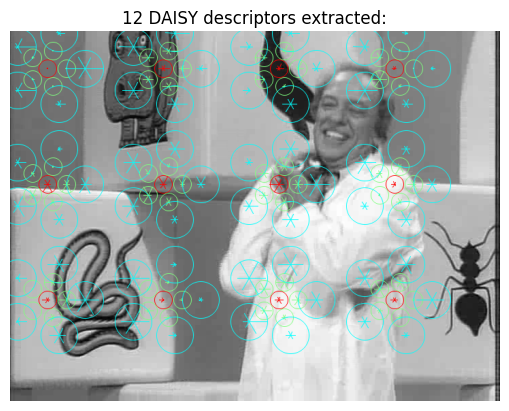

In [46]:
frame_idx = np.random.randint(0, len(dataset.frames[0]))
descriptors, img = extract_daisy(0, dataset.frames[0][frame_idx][1], visualize=True)

fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(img)
descs_num = descriptors.shape[0] * descriptors.shape[1]
ax.set_title("%i DAISY descriptors extracted:" % descs_num)
plt.show()


In this part, we extracted 12 daisy descriptors for each frame (in grayscale, as expected by the feature extractor) and stored those in our dataset as features. The daisy descriptors can be visualized above on a random frame of the first video.  
To obtain a feature vector for a given frame, we flatten the 12 descriptors into a 1D array of length $3 \times 4 \times 66 = 792$.


### Features for the Swedish Chef

As for the Swedish chef, a distinct characteristic of his appearances is his motion patterns where he moves a lot and distinctly.
For that reason, we focus on extracting motion features from the frames. We do that by experimenting with the Lucas-Kanade method and with the Farneback algorithm (Farneback optical flow). Then, at the classification stage, we will experiment with including them both or each one of them exclusively to see which approach performs better.

The Farneback algorithm is a an optical flow technique that computes the motion vector for every pixel in the frame. It estimates the motion between two image frames based on polynomial expansion. By approximating the neighborhoods of each pixel as quadratic, it calculates how these polynomials shift between frames. The Lucas-Kanade method is a sparse optical flow technique that estimates the motion of specific features in the image. It does so by assuming that the motion of these features is constant in a small neighborhood of the pixel. It then estimates the motion of these features by solving a least-squares problem.

The main difference between both approaches is that Farneback provides a motion vector for every pixel (dense), while Lucas-Kanade focuses on specific features (sparse). Thus, the first method is more expensive and leads to a larger feature vector in general, and is more adapted to cases where detailed, pixel-level motion information is needed.


**Extracting Lucas-Kanade features:**


In [160]:
def optical_flow(video_idx, frame_path, previous_frame_path):
    frame = cv2.imread(f"../data/video/{video_idx}/{frame_path}")
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    previous_frame = cv2.imread(f"../data/video/{video_idx}/{previous_frame_path}")
    previous_frame = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    # Detect good features to track
    p0 = cv2.goodFeaturesToTrack(
        previous_frame,
        maxCorners=100,
        qualityLevel=0.3,
        minDistance=7,
        blockSize=7,
        mask=None,
    )
    # Calculate optical flow
    if p0 is None:
        # Handle the case where no features are found
        return {
            "displacement_norm": 0,
            "velocity_norm": 0,
            "displacement_mean": 0,
            "velocity_mean": 0,
            "displacement_std": 0,
            "velocity_std": 0,
            "displacement_max": 0,
            "velocity_max": 0,
            "displacement_min": 0,
            "velocity_min": 0,
        }

    p1, st, err = cv2.calcOpticalFlowPyrLK(previous_frame, frame, p0, None, **lk_params)
    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Extracting movement features (displacement between old & new positions, velocity as the rate of change of the object's position)
    features = {}
    diff = good_new - good_old
    features["displacement_norm"] = np.linalg.norm(diff)
    features["velocity_norm"] = features["displacement_norm"] / (1 / dataset.frame_rate)
    features["displacement_mean"] = np.mean(diff)
    features["velocity_mean"] = features["displacement_mean"] / (1 / dataset.frame_rate)
    features["displacement_std"] = np.std(diff)
    features["velocity_std"] = features["displacement_std"] / (1 / dataset.frame_rate)
    try:
        features["displacement_max"] = np.max(diff)
        features["velocity_max"] = features["displacement_max"] / (
            1 / dataset.frame_rate
        )
        features["displacement_min"] = np.min(diff)
        features["velocity_min"] = features["displacement_min"] / (
            1 / dataset.frame_rate
        )
    except:
        features["displacement_max"] = 0
        features["velocity_max"] = 0
        features["displacement_min"] = 0
        features["velocity_min"] = 0
    return features


In [161]:
for video_idx in dataset.frames.keys():
    for frame_idx, frame_path in tqdm(
        dataset.frames[video_idx],
        desc="Extracting Lucas-Kanade flow features for video {}".format(video_idx),
    ):
        features = optical_flow(
            video_idx,
            frame_path,
            dataset.frames[video_idx][frame_idx - 1][1]
            if frame_idx > 0
            else frame_path,
        )  # for the first frame, we duplicate the frame -> no motion
        # Add extracted features to dataset
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_norm"
        ] = features["displacement_norm"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_norm"
        ] = features["velocity_norm"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_mean"
        ] = features["displacement_mean"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_mean"
        ] = features["velocity_mean"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_std"
        ] = features["displacement_std"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_std"
        ] = features["velocity_std"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_max"
        ] = features["displacement_max"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_max"
        ] = features["velocity_max"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_min"
        ] = features["displacement_min"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_min"
        ] = features["velocity_min"]


Extracting Lucas-Kanade flow features for video 0:   0%|          | 0/38681 [00:00<?, ?it/s]

Extracting Lucas-Kanade flow features for video 0:   1%|          | 340/38681 [00:04<10:20, 61.77it/s]/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value e

In [162]:
# Serialization of the extracted features due to long runtime
with open("../results/sim2_visual/daisy_lk.pkl", "wb") as f:
    pickle.dump(dataset.video_features, f)


In [ ]:
with open("../results/sim2_visual/daisy_lk.pkl", "rb") as f:
    dataset.video_features = pickle.load(f)


**Extracting Farneback optical flow features:**


In [163]:
def farneback_optical_flow(video_idx, frame_path, previous_frame_path):
    frame = cv2.imread(f"../data/video/{video_idx}/{frame_path}")
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    previous_frame = cv2.imread(f"../data/video/{video_idx}/{previous_frame_path}")
    previous_frame = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(
        previous_frame, frame, None, 0.5, 3, 15, 3, 5, 1.2, 0
    )
    # At this stage, the flow vector is a 2d array.
    # For each pixel [i, j], flow[i, j] gives the displacement vector [Δx, Δy] representing the motion of that pixel between the two frames.

    # We reduce noise by applying a Gaussian blur to the flow vector.
    # This is done by convolving the flow vector with a Gaussian kernel.
    flow_blurred = cv2.GaussianBlur(flow, (5, 5), 0)
    # Then we perform thresholding to remove low displacement values (most probably noise).
    magnitude, angle = cv2.cartToPolar(flow_blurred[..., 0], flow_blurred[..., 1])
    # Create a mask where the magnitude is greater than the threshold
    magnitude_mask = magnitude > 2.0
    flow_thresholded = np.zeros_like(flow_blurred)
    flow_thresholded[magnitude_mask] = flow_blurred[magnitude_mask]

    # Finally, we create aggregated statistics for the flow vector that will be our features
    mean_flow = np.mean(flow_thresholded, axis=(0, 1))
    std_flow = np.std(flow_thresholded, axis=(0, 1))
    # Histograms of flow orientations & magnitudes
    num_bins = 8
    hist_angle = np.histogram(angle, bins=num_bins, range=(0, 2 * np.pi))[0]
    hist_magnitude = np.histogram(magnitude, bins=num_bins)[0]

    # Dividing frame into a grid and extracting features for each cell
    grid_size = 8
    h, w = flow.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size

    grid_features = []
    for i in range(0, h, cell_h):
        for j in range(0, w, cell_w):
            cell_flow = flow[i : i + cell_h, j : j + cell_w]
            cell_mean = np.mean(cell_flow, axis=(0, 1))
            grid_features.append(cell_mean)

    features = {
        "mean_flow": mean_flow,
        "std_flow": std_flow,
        "hist_angle": hist_angle,
        "hist_magnitude": hist_magnitude,
        "grid_features": grid_features,
    }
    return features


In [164]:
for video_idx in dataset.frames.keys():
    for frame_idx, frame_path in tqdm(
        dataset.frames[video_idx],
        desc="Extracting farneback flow features for video {}".format(video_idx),
        leave=False,
    ):
        features = farneback_optical_flow(
            video_idx,
            frame_path,
            dataset.frames[video_idx][frame_idx - 1][1]
            if frame_idx > 0
            else frame_path,
        )  # for the first frame, we duplicate the frame -> no motion
        # Add extracted features to dataset
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_mean_flow"
        ] = features["mean_flow"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_std_flow"
        ] = features["std_flow"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_hist_angle"
        ] = features["hist_angle"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_hist_magnitude"
        ] = features["hist_magnitude"]
        dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_grid_features"
        ] = features["grid_features"]


Extracting farneback flow features for video 0:   0%|          | 0/38681 [00:00<?, ?it/s]

In [165]:
# Serialization of the extracted features due to long runtime
with open("../results/sim2_visual/daisy_lk_fb.pkl", "wb") as f:
    pickle.dump(dataset.video_features, f)


In [ ]:
with open("../results/sim2_visual/daisy_lk_fb.pkl", "rb") as f:
    dataset.video_features = pickle.load(f)


### Merge into the dataframe that will be used for model training & prepare the model dataset

We merge all extracted features into a single dataframe.


In [224]:
counter = 0
video_features = pd.DataFrame()
for video_idx in range(3):
    for frame_idx in tqdm(
        range(len(dataset.video_features[video_idx]["frames"])),
        desc=f"Extracting features for video {video_idx}",
    ):
        daisy = dataset.video_features[video_idx]["frames"][frame_idx]["daisy"]
        lk_displacement_norm = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_norm"
        ]
        lk_displacement_mean = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_mean"
        ]
        lk_displacement_std = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_std"
        ]
        lk_displacement_min = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_min"
        ]
        lk_displacement_max = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_displacement_max"
        ]
        lk_velocity_norm = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_norm"
        ]
        lk_velocity_mean = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_mean"
        ]
        lk_velocity_std = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_std"
        ]
        lk_velocity_min = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_min"
        ]
        lk_velocity_max = dataset.video_features[video_idx]["frames"][frame_idx][
            "lk_velocity_max"
        ]
        fb_mean_flow = dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_mean_flow"
        ]
        fb_std_flow = dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_std_flow"
        ]
        fb_hist_angle = dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_hist_angle"
        ]
        fb_hist_magnitude = dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_hist_magnitude"
        ]
        fb_grid_features = dataset.video_features[video_idx]["frames"][frame_idx][
            "fb_grid_features"
        ]
        fb_grid_features = np.vstack(fb_grid_features).flatten()

        frame_features = {
            "video_idx": video_idx,
            "frame_idx": frame_idx,
            **{"daisy_" + str(i): val for i, val in enumerate(daisy[0])},
            "lk_displacement_norm": lk_displacement_norm,
            "lk_displacement_mean": lk_displacement_mean,
            "lk_displacement_std": lk_displacement_std,
            "lk_displacement_min": lk_displacement_min,
            "lk_displacement_max": lk_displacement_max,
            "lk_velocity_norm": lk_velocity_norm,
            "lk_velocity_mean": lk_velocity_mean,
            "lk_velocity_std": lk_velocity_std,
            "lk_velocity_min": lk_velocity_min,
            "lk_velocity_max": lk_velocity_max,
            **{"fb_mean_flow_" + str(i): val for i, val in enumerate(fb_mean_flow)},
            **{"fb_std_flow_" + str(i): val for i, val in enumerate(fb_std_flow)},
            **{"fb_hist_angle_" + str(i): val for i, val in enumerate(fb_hist_angle)},
            **{
                "fb_hist_magnitude_" + str(i): val
                for i, val in enumerate(fb_hist_magnitude)
            },
            **{
                "fb_grid_features_" + str(i): val
                for i, val in enumerate(fb_grid_features)
            },
        }

        video_features = pd.concat(
            [video_features, pd.DataFrame(frame_features, index=[counter])],
            ignore_index=True,
        )
        counter += 1

# Add annotations
video_features = video_features.merge(
    dataset.annotations[["Video", "Frame_number", "Pigs", "Cook"]],
    how="left",
    left_on=["video_idx", "frame_idx"],
    right_on=["Video", "Frame_number"],
)
video_features = video_features.drop(columns=["Frame_number", "Video"])


Extracting features for video 2: 100%|██████████| 38498/38498 [1:06:56<00:00,  9.59it/s]


In [225]:
video_features.to_csv("../results/sim2_visual/daisy.csv")


In [256]:
video_features1 = pd.read_csv("../results/sim2_visual/daisy.csv")
video_features2 = pd.read_csv("../results/sim2_visual/lucas-kanade_farneback.csv")

video_features = pd.merge(
    video_features1,
    video_features2,
    on=["video_idx", "frame_idx", "Pigs", "Cook"],
    how="inner",
).drop(columns=["Unnamed: 0_x", "Unnamed: 0_y"], axis=1)


Sanity check:


In [258]:
assert dataset.annotations.shape[0] == video_features.shape[0]
assert dataset.annotations["Pigs"].sum() == video_features["Pigs"].sum()
np.testing.assert_array_equal(
    dataset.annotations["Pigs"].values, video_features["Pigs"].values
)
np.testing.assert_array_equal(
    dataset.annotations["Cook"].values,
    video_features["Cook"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Video"].values,
    video_features["video_idx"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Frame_number"].values,
    video_features["frame_idx"].values,
)


In [259]:
video_features.sample(10)


,video_idx,frame_idx,daisy_0,daisy_1,daisy_2,daisy_3,daisy_4,daisy_5,daisy_6,daisy_7,...,fb_grid_features_118,fb_grid_features_119,fb_grid_features_120,fb_grid_features_121,fb_grid_features_122,fb_grid_features_123,fb_grid_features_124,fb_grid_features_125,fb_grid_features_126,fb_grid_features_127
62862,1,24181,0.001081,0.001211,0.001658,0.002555,0.002753,0.002172,0.000970,0.000905,...,6.571276e-01,0.730121,0.509629,4.090702,1.049024e+00,0.805754,1.292122e-01,-0.183760,-0.000331,0.000211
114022,2,36635,0.010663,0.009224,0.008328,0.009858,0.013114,0.013007,0.007324,0.005919,...,2.533574e+00,2.905390,1.981608,11.045300,2.800087e+00,0.184889,1.910237e-01,0.030544,1.547014,0.057762
37094,0,37094,0.019418,0.010785,0.014268,0.033064,0.017557,0.011431,0.024102,0.011983,...,-2.526790e+00,0.815570,-2.769699,1.726610,-6.742489e+00,4.842618,-3.908169e+00,0.302243,0.747103,-0.207838
79829,2,2442,0.009052,0.015184,0.016088,0.012490,0.017802,0.016133,0.002637,0.003362,...,4.108461e-07,0.000013,-0.000004,0.000002,9.990042e-07,0.000004,-2.832650e-07,0.000003,-0.000050,0.000155
108657,2,31270,0.017101,0.027108,0.022511,0.013401,0.024100,0.025113,0.009850,0.014247,...,3.124642e+00,0.386474,0.275703,0.028044,8.259150e-02,-0.033050,-2.365337e-01,0.280802,0.424988,0.332480
54063,1,15382,0.006018,0.019122,0.015565,0.005764,0.009045,0.007544,0.009032,0.027700,...,7.900882e-03,-0.079465,-0.000544,-0.003610,3.023708e-04,-0.000008,9.208727e-05,-0.000084,-0.003539,-0.000325
104604,2,27217,0.009943,0.005521,0.004392,0.008600,0.009313,0.008205,0.021375,0.010979,...,3.807145e-04,0.000054,-0.000331,0.000489,-1.832958e-04,0.000011,-2.940404e-05,0.001025,-0.007484,0.030267
816,0,816,0.009830,0.024691,0.028258,0.012189,0.020056,0.019894,0.009448,0.024122,...,6.956587e-03,-0.000943,0.094350,0.005908,2.658875e-01,-0.004324,2.115532e-01,-0.038204,0.045903,-0.024603
78790,2,1403,0.013886,0.013357,0.010839,0.020596,0.020642,0.011937,0.018084,0.017407,...,1.551068e-02,0.006997,-0.004292,0.000851,-2.154816e-02,-0.008165,-6.734641e-02,-0.015308,0.076947,-0.011374
62116,1,23435,0.001280,0.001099,0.001979,0.004091,0.004275,0.003156,0.002192,0.001253,...,-1.738859e+00,2.602129,-0.674328,2.591901,1.664925e-01,2.165668,3.796956e-01,0.386737,-0.001049,0.004340


In [260]:
video_features.describe()


,video_idx,frame_idx,daisy_0,daisy_1,daisy_2,daisy_3,daisy_4,daisy_5,daisy_6,daisy_7,...,fb_grid_features_118,fb_grid_features_119,fb_grid_features_120,fb_grid_features_121,fb_grid_features_122,fb_grid_features_123,fb_grid_features_124,fb_grid_features_125,fb_grid_features_126,fb_grid_features_127
count,115885.000000,115885.000000,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,1.158850e+05,...,1.158850e+05,115885.000000,115885.000000,1.158850e+05,115885.000000,115885.000000,115885.000000,1.158850e+05,115885.000000,1.158850e+05
mean,0.998421,19313.777952,1.068304e-02,1.013311e-02,1.033687e-02,1.191105e-02,1.176136e-02,1.104058e-02,1.080637e-02,1.056926e-02,...,-4.679119e-02,-0.123808,-0.027750,-1.331260e-01,-0.025021,-0.074036,-0.033398,-6.215253e-03,-0.034288,-2.295277e-03
std,0.816088,11151.279978,7.783094e-03,6.442540e-03,6.281983e-03,7.686735e-03,6.962839e-03,6.917617e-03,8.068956e-03,7.162475e-03,...,2.435524e+00,2.676419,2.384794,2.751083e+00,2.261941,2.550775,2.185725,2.008444e+00,1.913913,1.716145e+00
min,0.000000,0.000000,2.085598e-08,2.085598e-08,2.085598e-08,2.085598e-08,2.085598e-08,2.085598e-08,4.060539e-08,4.060539e-08,...,-3.672614e+01,-46.780933,-33.832546,-3.867071e+01,-32.410220,-35.533646,-33.876730,-3.469725e+01,-37.570510,-3.466613e+01
25%,0.000000,9657.000000,4.796774e-03,4.829900e-03,5.353153e-03,6.608745e-03,6.390424e-03,5.620405e-03,4.899096e-03,5.072721e-03,...,-2.850232e-01,-0.190642,-0.255549,-1.804155e-01,-0.235074,-0.150199,-0.151204,-7.182454e-02,-0.059166,-4.241758e-02
50%,1.000000,19314.000000,9.563252e-03,9.403566e-03,9.208235e-03,1.075136e-02,1.085466e-02,9.891039e-03,9.533631e-03,9.186902e-03,...,3.485086e-07,0.000000,0.000364,-6.234745e-08,0.000020,0.000000,0.000023,6.862473e-11,-0.000041,-1.196364e-08
75%,2.000000,28971.000000,1.485998e-02,1.428662e-02,1.438812e-02,1.537599e-02,1.588491e-02,1.527079e-02,1.461787e-02,1.546292e-02,...,2.697848e-01,0.176623,0.265828,1.613276e-01,0.254884,0.134242,0.183591,8.171061e-02,0.070578,4.894003e-02
max,2.000000,38705.000000,8.279600e-02,6.309712e-02,5.772268e-02,8.329849e-02,5.750292e-02,5.283140e-02,8.294338e-02,1.025069e-01,...,4.167941e+01,90.501420,42.101242,7.672279e+01,35.268105,65.010240,35.808820,3.257896e+01,60.026142,3.553133e+01


In [261]:
video_features.fillna(0, inplace=True)


We extract the `X` and `y` matrices for the model:


In [262]:
# We extract the `X` and `y` matrices for the model, and then split into train and test sets by a 80/20 ratio
X = video_features.drop(columns=["Pigs", "Cook", "video_idx", "frame_idx"])
y = video_features[["Pigs", "Cook"]]


And then split into train and test sets by a 80/20 ratio.
However, we do not use a shuffled random split like one would often use in tabular-data machine learning: this would lead to test-set contamination, as neighboring frames are highly correlated, and we would have such neighboring frames in both the train and test sets.  
However, to observe the difference in results, we implemented both the random and non-random approaches and tried out both.

Due to this reasoning, we decide to use the first 80% of the ordered frames as training data and the last 20% as testing data.


In [263]:
RANDOM_SPLIT = True  # Change this boolean to experiment with one option or another


In [264]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]


## Training the vision-based model


For this task, we decide to use a random forest classifier. We chose this specific model due to the daisy feature extractor that leads to a large feature vector. Random forests are known to perform well on high-dimensional data, and are also pretty robust to overfitting (in comparison to non-ensemble methods). This is why we use this model here, even if it was talked about in the Sim1 lecture. To ensure that we respect the demand for 3 "complex" methods from Sim2, we used a SVM classifier (from Sim2) in the video-based model of Sim1 to compensate for the use of a random forest here.

Right now, the `y` matrix one-hot encodes the labels, but we need to convert it to a single column of labels for the classifier, where:

- 0: neither pigs nor the Swedish chef are present
- 1: Pigs are present
- 2: The Swedish chef is present
- 3: both are present


In [265]:
y_train = np.argmax(y_train, axis=1) + np.any(y_train, axis=1)
y_test = np.argmax(y_test, axis=1) + np.any(y_test, axis=1)


def convert_predictions_to_one_hot(predictions):
    y_pred_one_hot = np.zeros((predictions.size, y_train.shape[1]))
    y_pred_one_hot[
        np.arange(predictions.size), predictions - np.any(y_train, axis=1)
    ] = 1


**Training the random forest classifier while determining the best hyperparameter combination through grid search:**


In [266]:
param_grid = {
    "max_depth": [3, 5, 10, None],
    "n_estimators": [10, 100, 200],
    "max_features": [1, 3, 5, 7],
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [1, 2, 3],
}
grid_search = GridSearchCV(
    RandomForestClassifier(), param_grid, cv=3, scoring="recall_weighted"
)  # We optimize for recall because in experiments, false negatives were the biggest problem
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print(grid_search.best_params_)
y_pred = best_rf.predict(X_test)


{}


## Evaluating the model


In [267]:
# Convert labels for the first character
y_test_pigs = (y_test == 1) | (y_test == 3)
y_pred_pigs = (y_pred == 1) | (y_pred == 3)

# Convert labels for the second character
y_test_cook = (y_test == 2) | (y_test == 3)
y_pred_cook = (y_pred == 2) | (y_pred == 3)


# Compute metrics for the first character
accuracy_pigs = accuracy_score(y_test_pigs, y_pred_pigs)
precision_pigs = precision_score(y_test_pigs, y_pred_pigs)
recall_pigs = recall_score(y_test_pigs, y_pred_pigs)
f1_pigs = f1_score(y_test_pigs, y_pred_pigs)
map_pigs = average_precision_score(y_test_pigs, y_pred_pigs)

# Compute metrics for the second character
accuracy_cook = accuracy_score(y_test_cook, y_pred_cook)
precision_cook = precision_score(y_test_cook, y_pred_cook)
recall_cook = recall_score(y_test_cook, y_pred_cook)
f1_cook = f1_score(y_test_cook, y_pred_cook)
map_cook = average_precision_score(y_test_cook, y_pred_cook)

# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test, y_pred)
precision_general = precision_score(y_test, y_pred, average="weighted")
recall_general = recall_score(y_test, y_pred, average="weighted")
f1_general = f1_score(y_test, y_pred, average="weighted")


***General model metrics***
	Accuracy: 0.9934417741726712
	Precision: 0.9934538278999971
	Recall: 0.9934417741726712
	F1: 0.9934139743772142
***Pigs***
	Accuracy: 0.994390991068732
	Precision: 0.9948320413436692
	Recall: 0.9751323969606263
	F1: 0.9848837209302325
	MAP: 0.9747527450838923
***Swedish chef***
	Accuracy: 0.9989644906588429
	Precision: 0.9983333333333333
	Recall: 0.9630225080385852
	F1: 0.9803600654664484
	MAP: 0.9624098336437965


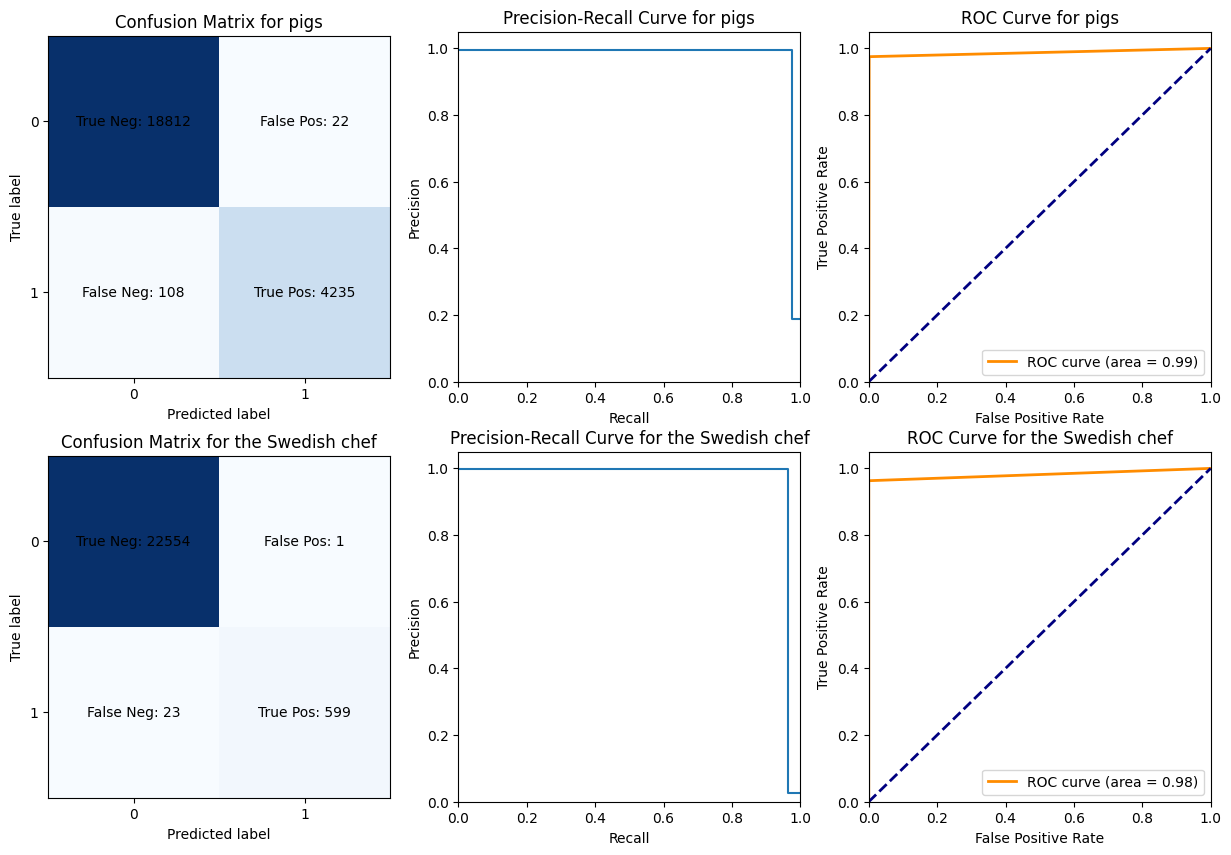

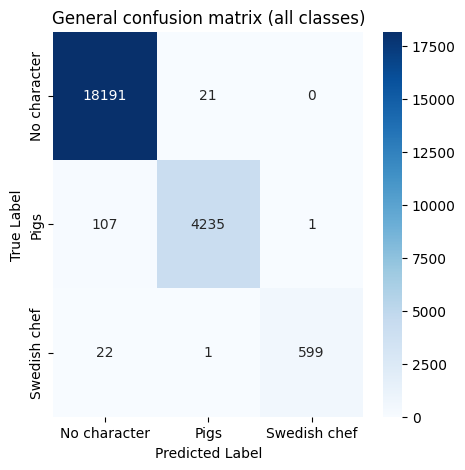

In [268]:
# *** Metrics ***
print(
    f"***General model metrics***\n\tAccuracy: {accuracy_general}\n\tPrecision: {precision_general}\n\tRecall: {recall_general}\n\tF1: {f1_general}"
)
print(
    f"***Pigs***\n\tAccuracy: {accuracy_pigs}\n\tPrecision: {precision_pigs}\n\tRecall: {recall_pigs}\n\tF1: {f1_pigs}\n\tMAP: {map_pigs}"
)
print(
    f"***Swedish chef***\n\tAccuracy: {accuracy_cook}\n\tPrecision: {precision_cook}\n\tRecall: {recall_cook}\n\tF1: {f1_cook}\n\tMAP: {map_cook}"
)

# *** Visual evaluation ***
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# Pigs
plot_confusion_matrix(
    y_test_pigs, y_pred_pigs, "Confusion Matrix for pigs", ax=axs[0, 0]
)
plot_precision_recall_curve(
    y_test_pigs, y_pred_pigs, "Precision-Recall Curve for pigs", ax=axs[0, 1]
)
plot_roc_curve(y_test_pigs, y_pred_pigs, "ROC Curve for pigs", ax=axs[0, 2])
# Swedish chef
plot_confusion_matrix(
    y_test_cook,
    y_pred_cook,
    "Confusion Matrix for the Swedish chef",
    ax=axs[1, 0],
)
plot_precision_recall_curve(
    y_test_cook,
    y_pred_cook,
    "Precision-Recall Curve for the Swedish chef",
    ax=axs[1, 1],
)
plot_roc_curve(y_test_cook, y_pred_cook, "ROC Curve for the Swedish chef", ax=axs[1, 2])
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_global_confusion_matrix(
    y_test,
    y_pred,
    "Pigs",
    "Swedish chef",
)


### Result discussion, observations and other things we tried to improve performance

As in Similarity Modeling 1, the performance of the model has been evaluated under three angles:

- Pigs classification (_metrics/plots for success at classifying frames where the Pigs flag is true_).
- Swedish Chef classification (_metrics/plots for success at classifying frames where the Swedish chef flag is true_).
- Overall classification performance (_metrics/plots for the general multi-class classification task - weighted performance metrics have been employed_).

The best performing model uses the following features (_explanations on why we chose them for characteristics of the characters are given in the feature extraction part of the notebook_):

- **DAISY descriptors**: 12 descriptors per frame, flattened into a 1D array of length $3 \times 4 \times 66 = 792$. These features describe local regions of the image and are invariant to rotation and scale through the use of circularly symmetric kernels. They are extracted in grayscale, and mainly were chosen as a way to detect specific shapes (e.g. the discriminative pigs' snouts where the pink color would not suffice).
- **Lucas-Kanade optical flow**: 10 features per frame. These features describe the motion of specific features in the image. For each frame, we extract the descriptors and use them to compute velocity and displacement, and compute different statistical moments of those properties. The descriptors are extracted in grayscale, and were chosen as a way to detect the motion of the Swedish chef, which is a very distinct characteristic of his appearances. The Lucas-Kanade method is a sparse optical flow technique that estimates the motion of specific features in the image. It does so by assuming that the motion of these features is constant in a small neighborhood of the pixel. It then estimates the motion of these features by solving a least-squares problem.
- **Farneback optical flow**: This algorithm was tested as an alternative/complement to the Lucas-Kanade algorithm. The extracted features are different as they describe the motion of every pixel in the image in this case (_dense vs. sparse optical flow_). For each frame, we extract the descriptors and this time compute statistical moments of the flow, but also derive histograms of the angle and magnitude of displacement. Another derived feature is that we divide the image into a grid, and compute similar aggregates for each cell of that grid (square in the image) for more precise regional descriptors.

These features are fed, as a vector of values, into a random forest classifier. We chose this specific model due to the daisy feature extractor that leads to a large feature vector. Random forests are known to perform well on high-dimensional data, and are also pretty robust to overfitting (in comparison to non-ensemble methods). This is why we use this model here, even if it was talked about in the Sim1 lecture. To ensure that we respect the demand for 3 "complex" methods from Sim2, we used a SVM classifier (from Sim2) in the video-based model of Sim1 to compensate for the use of a random forest here. The model hyperparameters have been tuned through grid search.

The model has been evaluated on a random split of the dataset, where 80% of the frames are used for training and 20% for testing. The evaluation has been performed for the non-random split implemented and described in Sim 1 Audio as well, but as those two approaches have been discussed and compared extensively in that notebook, we will focus on the random split here. The metrics and curves for the non-random split are available in `results/sim2_visual`.  
In this setup, the best performing model, using a combination of all features described above, achieves the following performance metrics:

**Performance all three feature-extractors:**

<table>
<thead>
  <tr>
    <th><b>Classification task</b></th>
    <th><b>F1</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Pigs detection</b></td>
    <td>0.9849</td>
    <td>0.0.9944</td>
    <td>0.9948</td>
    <td>0.9751</td>
  </tr>
  <tr>
    <td><b>Swedish Chef detection</b></td>
    <td>0.9804</td>
    <td>0.999</td>
    <td>0.9983</td>
    <td>0.963</td>
  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.9934</td>
    <td>0.9934</td>
    <td>0.9935</td>
    <td>0.9934</td>
  </tr>
</tbody>
</table>
<img src="../results/sim2_visual/all_randomsplit.png" style="max-width:75%; display: block; margin: 0 auto">

In comparison, this is the performance with only the daisy features.  
**Performance with the non-random split:**

<table>
<thead>
  <tr>
    <th><b>Classification task</b></th>
    <th><b>F1</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Pigs detection</b></td>
    <td>0.9777</td>
    <td>0.9918</td>
    <td>0.9952</td>
    <td>0.9609</td>
  </tr>
  <tr>
    <td><b>Swedish Chef detection</b></td>
    <td>0.9828</td>
    <td>0.9991</td>
    <td>1</td>
    <td>0.9662</td>
  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.9909</td>
    <td>0.9909</td>
    <td>0.9909</td>
    <td>0.9909</td>
  </tr>
</tbody>
</table>
<img src="../results/sim2_visual/daisy_randomsplit.png" style="max-width:75%; display: block; margin: 0 auto">

Similarly, this is the performance with only the two motion-based feature-extractors.  
**Performance with Lucas-Kanade and Farneback optical flow:**

<table>
<thead>
  <tr>
    <th><b>Classification task</b></th>
    <th><b>F1</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Pigs detection</b></td>
    <td>0.5244</td>
    <td>0.8785</td>
    <td>0.9829</td>
    <td>0.3576</td>
  </tr>
  <tr>
    <td><b>Swedish Chef detection</b></td>
    <td>0.4313</td>
    <td>0.9805</td>
    <td>1</td>
    <td>0.2749</td>
  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.8311</td>
    <td>0.8593</td>
    <td>0.8782</td>
    <td>0.8593</td>
  </tr>
</tbody>
</table>
<img src="../results/sim2_visual/lk_fb_randomsplit.png" style="max-width:75%; display: block; margin: 0 auto">

**These different kinds of features, as well as their combinations, are the result of many experiments to improve the final performance.** For example, at the beginning, the entire extracted features were fed before their aggregates. Some more advanced aggregates (the angle histograms, or the division of the frames into grids for which we extracted individual features) have also been introduced in the process of evaluating the performance with only the general motion-based features and then trying to improve that performance.

The numbers and figures displayed above are the result of the best performance we achieved with each family of features. What we observe from our experiments is that the daisy features are the most discriminative, and that the motion-based features are not as useful for the classification task in general. This is probably due to the fact that the motion-based features are not very discriminative, and that the daisy features are already very good at classifying the videos. While adding the motion information to the daisy features does improve performance, the different is not dramatic (a few percents) because the performance was already very good. The motion features by themselves lead to a worse classifier, which was to a certain extent expected. However, we are surprised that this is also the case for the Swedish Chef detection task, where we expected the motion features to be more useful. This might be because our specific flow description technique does not capture the Swedish chef movement patterns very well, or because they are not sufficiently disciminative by themselves.

During our experiments, we also experienced that classification performance is not the only thing that should be considered when choosing these techniques as their runtime can be significantly longer than for the audio feature extraction techniques we tried. Indeed, the daisy features are extremely slow to extract, magnitudes longer than the motion features. Extracting them for the entire dataset took about 20 hours, while the motion features were extracted in about an hour. This made iterative improvement, debugging and experiments quite tedious. The daisy features are very powerful but cost a lot to compute, and we found that this tradeoff can be tuned by reducing the number of keypoints and/or the number of histograms. By doing so, performance decreases slightly while making extraction cheaper.
